# Causal Inference
## Задание CI.4


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

---


**Баллы за задание:**

* Задача 1 — 100 баллов
* Задача 2 — 30 баллов

In [111]:
# Bot check

# HW_ID: ds_ci4
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [112]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error as mape

from scipy.optimize import fmin_slsqp
from typing import List
from operator import add
from toolz import reduce, partial

from toolz import partial
from joblib import Parallel, delayed

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import scipy.stats as sps
import pymc as pm
from collections import defaultdict

from xgboost import XGBRegressor
from dowhy import CausalModel

from IPython.display import display

sns.set(font_scale=1.2, palette='Set2')

---
### Задача 1.

Рассмотрим данные Walmart из задачи AB.4.5. Предположим, что сеть небольшая, и состоит только из 45 магазинов, которые представлены в данных. Кроме того, финансовые риски при проведении экспериментов довольно высоки, поэтому для проверки различных инициатив разрешено брать в тестовую группу только один магазин. При этом в компании установлена допустимая вероятность ошибки 1 рода на уровне 20%.

**1.** Пришел заказчик с новой бизнес-инициативой. Выберите один магазин, который вам больше понравится. Помните, чем магазин является более "типичным", тем более надежными будут результаты.

In [113]:
train = pd.read_csv("archive/train.csv")
stores = pd.read_csv("archive/stores.csv")
features = pd.read_csv("archive/features.csv")

In [114]:
train["Date"] = pd.to_datetime(train["Date"])
train = train.groupby(["Store", "Date"])["Weekly_Sales"].sum().reset_index()
train.head()

,Store,Date,Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68


Типичный магазин определим по среднему размеру.

In [115]:
avg_size = stores['Size'].mean()
average_store_index = np.argmin(np.abs(stores['Size'] - avg_size))
average_store = stores.iloc[average_store_index]
train_store = train[train['Store'] == average_store['Store']]

In [116]:
average_store

Store        25
Type          B
Size     128107
Name: 24, dtype: object

In [117]:
train_store["Date"] = pd.to_datetime(train_store["Date"])
train_store = train_store.groupby('Date')['Weekly_Sales'].sum().reset_index()
train_store.set_index('Date', inplace=True)

In [118]:
train_store

,Weekly_Sales
Date,
2010-02-05,677231.63
2010-02-12,583364.02
2010-02-19,676260.67
2010-02-26,628516.57
2010-03-05,665750.06
...,...
2012-09-28,683300.84
2012-10-05,699536.73
2012-10-12,697317.41


Заказчик произвел работы в выбранном вами магазине в период 2-3 июня 2012. Добавьте искусственный эффект 5% к этому магазину.

In [119]:
experiment_start_date = pd.Timestamp('2012-06-02')
train_store.loc[train_store.index >= experiment_start_date, "Weekly_Sales"] *= 1.05

train_store

,Weekly_Sales
Date,
2010-02-05,677231.6300
2010-02-12,583364.0200
2010-02-19,676260.6700
2010-02-26,628516.5700
2010-03-05,665750.0600
...,...
2012-09-28,717465.8820
2012-10-05,734513.5665
2012-10-12,732183.2805


In [120]:
train["after_treatment"] = train["Date"] > experiment_start_date
train.head()

,Store,Date,Weekly_Sales,after_treatment
0,1,2010-02-05,1643690.90,False
1,1,2010-02-12,1641957.44,False
2,1,2010-02-19,1611968.17,False
3,1,2010-02-26,1409727.59,False
4,1,2010-03-05,1554806.68,False


Оцените эффект с помощью классического diff-in-diff, взяв еще один магазин в качестве контрольного. 

*Примечание.* Для оценки каждого составляющего для надежности стоит брать интервал 4 недели.

In [121]:
sorted_stores = stores.sort_values("Size")
diff_from_avg = (sorted_stores["Size"] - avg_size).abs()
second_largest_store_index = diff_from_avg[
    diff_from_avg != diff_from_avg.min()
].idxmin()
second_largest_store = sorted_stores.loc[second_largest_store_index]
control_store = train[train["Store"] == second_largest_store["Store"]]

second_largest_store

Store        10
Type          B
Size     126512
Name: 9, dtype: object

In [122]:
control_store["Date"] = pd.to_datetime(control_store["Date"])
control_store = control_store.groupby('Date')['Weekly_Sales'].sum().reset_index()
control_store.set_index('Date', inplace=True)

In [123]:
train_agg = train_store.groupby(train_store.index)['Weekly_Sales'].sum()
control_agg = control_store.groupby(control_store.index)['Weekly_Sales'].sum()

In [124]:
train_before = train_agg[train_agg.index < experiment_start_date]
train_after = train_agg[train_agg.index >= experiment_start_date]
control_before = control_agg[control_agg.index < experiment_start_date]
control_after = control_agg[control_agg.index >= experiment_start_date]

Применим diff-in-diff

In [125]:
delta_train = train_after.mean() - train_before.mean()
delta_control = control_after.mean() - control_before.mean()
diff_in_diff = delta_train - delta_control
print("Diff-in-Diff estimate =", diff_in_diff)

Diff-in-Diff estimate = 188609.8318290402


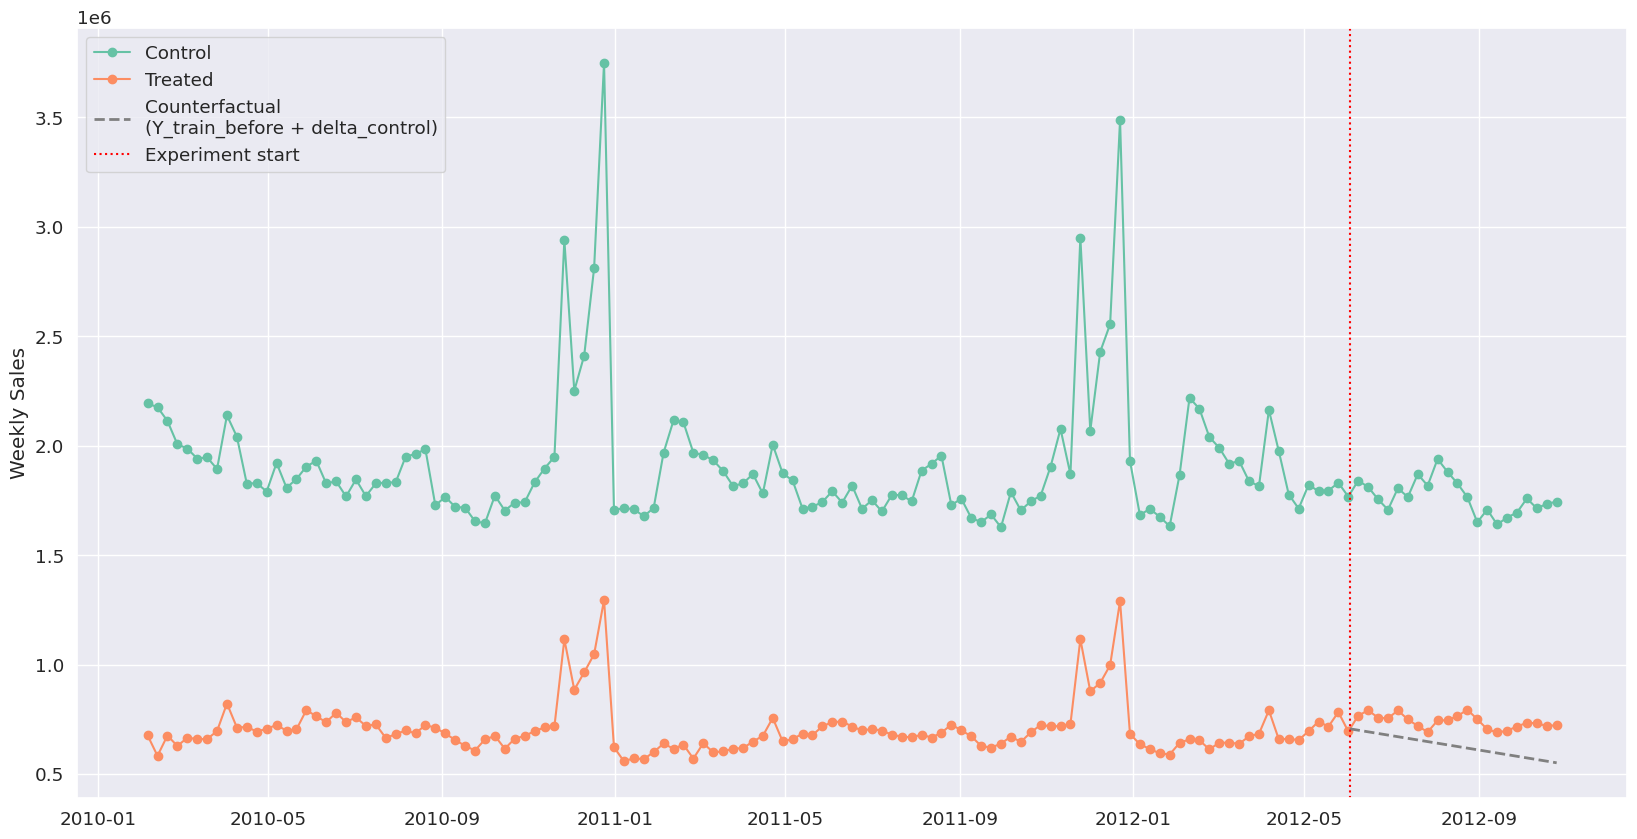

In [126]:
plt.figure(figsize=(20, 10))

plt.plot(control_agg.index, control_agg.values, label="Control", marker='o')
plt.plot(train_agg.index, train_agg.values, label="Treated", marker='o')

t1 = train_agg.index.max()
y0 = train_before.mean()
y1 = y0 + delta_control

plt.plot([experiment_start_date, t1], [y0, y1],
         label="Counterfactual\n(Y_train_before + delta_control)",
         color='gray', lw=2, ls='--')

plt.axvline(x=experiment_start_date, color='red', linestyle=':', label='Experiment start')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

Насколько "визуально" точной получилась оценка? В чем проблема классического diff-in-diff?

Как видим, контрфактивный прогноз оказался ниже действительных данных, что говорит о том, что эффект от эксперимента присутствует.

Основной проеблемой классического diff-in-diff является то, что мы предполагаем параллельный тренд, что в общем случае не всегда так. Из за этого в наша оценка может быть смещенной.


**2.** Перейдем к методу синтетического контроля. Постройте синтетический контроль с помощью линейной регрессии с регуляризацией, оцените эффект и постройте доверительный интервал.

Для обучения линейной регрессии не стоит брать слишком большую историю, достаточно будет 8-9 месяцев.

In [127]:
start_date = experiment_start_date - pd.Timedelta(days=30 * 8)

In [128]:
train.loc[(train["Store"] == average_store_index) & (train["Date"] >= experiment_start_date), "Weekly_Sales"] *= 1.05

In [129]:
tmp_train = train.copy()
tmp_train["Date"] = pd.to_datetime(tmp_train["Date"])
general_df = tmp_train.copy()

test_train = tmp_train[(tmp_train["Date"] > experiment_start_date)]
tmp_train = tmp_train[(tmp_train["Date"] <= experiment_start_date) & (tmp_train["Date"] >= start_date)]

general_df = general_df.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()
general_df.set_index('Date', inplace=True)
general_pivot = general_df.pivot(columns='Store', values='Weekly_Sales')

tmp_train = tmp_train.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()
tmp_train.set_index('Date', inplace=True)
train_pivot = tmp_train.pivot(columns='Store', values='Weekly_Sales')

general_df.head()

,Store,Weekly_Sales
Date,,
2010-02-05,1,1643690.90
2010-02-12,1,1641957.44
2010-02-19,1,1611968.17
2010-02-26,1,1409727.59
2010-03-05,1,1554806.68


In [130]:
treatment_index = average_store_index

y_train = train_pivot[treatment_index].values
X_train = train_pivot.drop(columns=[treatment_index]).values

X_test = general_pivot.drop(columns=[treatment_index]).values
y_test = general_pivot[treatment_index].values

In [131]:
model = Lasso(alpha=1, positive=True).fit(X_train, y_train)
model.coef_.round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.241, 0.   , 0.   ,
       0.15 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.3  , 0.137, 0.   ,
       0.113, 0.   , 0.   , 0.   , 0.594, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.329, 0.   , 0.   , 0.   , 0.   , 0.   ])

In [132]:
train["typycal_store"] = (train["Store"] == average_store_index)

In [133]:
def draw_synthetic_control(
    data,
    synthetic_control_values,
    treatment_plt_label="Типичный магазин",
    treatment_name="typycal_store",
    time_name="Date",
    target_plt_label="Недельные продажи",
    target_name="Weekly_Sales",
    pilot_label="Начало эксперимента",
    pilot_start=start_date,
):
    
    time = data.query(treatment_name)[time_name]
    target_values = data.query(treatment_name)[target_name]

    # рисуем первый график
    plt.figure(figsize=(10, 6))
    plt.plot(
        time, 
        target_values, 
        lw=3, label=treatment_plt_label
    )
    plt.plot(
        time, 
        synthetic_control_values, 
        lw=3, label="Синтетический контроль"
    )
    plt.vlines(
        x=pilot_start, 
        ymin=min(target_values.min(), synthetic_control_values.min()),
        ymax=min(target_values.max(), synthetic_control_values.max()),
        linestyle=":", 
        lw=3, color="magenta", label=pilot_label
    )
    plt.ylabel(target_plt_label)
    plt.legend()
    plt.title("Синтетический контроль")
    plt.show();

    # рисуем второй график
    plt.figure(figsize=(10, 6))
    plt.plot(
        time, 
        target_values - synthetic_control_values,
        label=f"Эффект для {treatment_plt_label}",
        lw=5
    )
    min_value = min(0, (target_values - synthetic_control_values).min())
    max_value = max(0, (target_values - synthetic_control_values).max())
    plt.vlines(
        x=pilot_start, ymin=min_value, ymax=max_value, linestyle=":", lw=3, 
        color="magenta", label=pilot_label
    )
    plt.hlines(y=0, xmin=data[time_name].min(), xmax=data[time_name].max(), lw=2, color="gray")
    plt.title("Разница с синтетическим контролем")
    plt.ylabel(target_plt_label)
    plt.legend()
    plt.show();

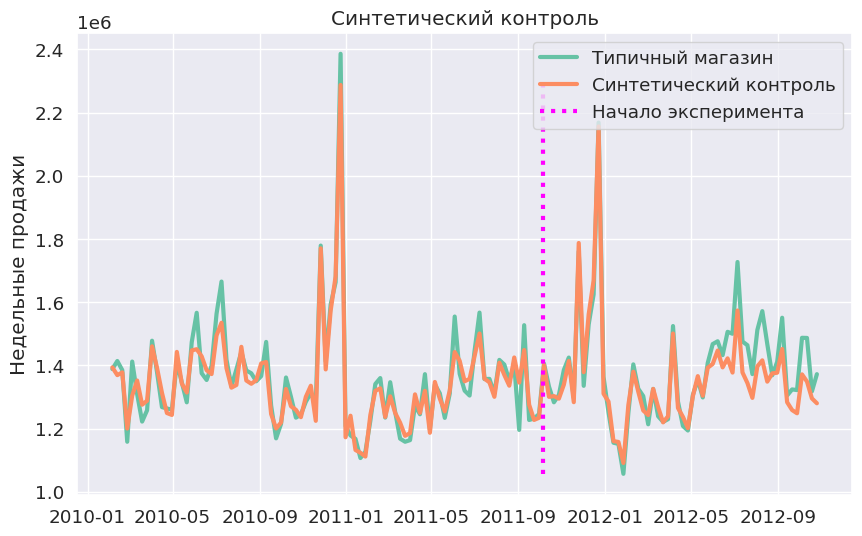

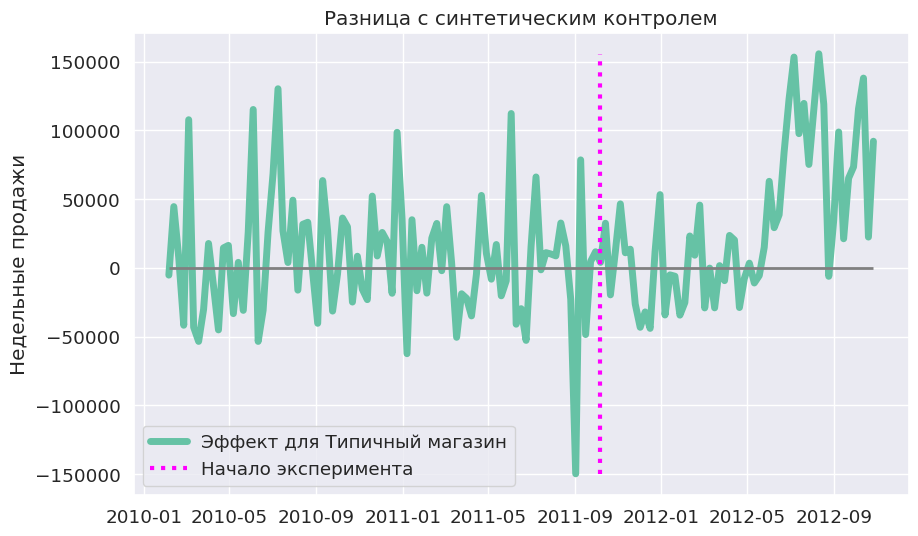

In [134]:
y_test_predict = model.predict(X_test)
draw_synthetic_control(train, y_test_predict)

Провалидируйте подход, оценив вероятность ошибки 1 рода и мощность. Для этого стоит произвести достаточное количество итераций метода Монте-Карло, на каждой из которых необходимо
* выбирать случайный магазин в качестве тестового,
* построить для него синтетический контроль,
* оценить его стат. значимость.

Проверьте, имеет ли смысл ставить ограничение на положительность коэффициентов линейной регрессии.

*Примечание.* Используйте параллельные вычисления как в примере с занятия. Желательно произвести не менее $1000$ итераций метода Монте-Карло. Если это занимает слишком долго (больше часа), можно сократить до $500$ итераций.

In [135]:
def synthetic_control(store, data, model):

    tmp_train = data.copy()
    tmp_train["Date"] = pd.to_datetime(tmp_train["Date"])
    general_df = tmp_train.copy()

    test_train = tmp_train[(tmp_train["Date"] > experiment_start_date)]
    tmp_train = tmp_train[(tmp_train["Date"] <= experiment_start_date) & (tmp_train["Date"] >= start_date)]

    general_df = general_df.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()
    general_df.set_index('Date', inplace=True)
    general_pivot = general_df.pivot(columns='Store', values='Weekly_Sales')

    tmp_train = tmp_train.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()
    tmp_train.set_index('Date', inplace=True)
    train_pivot = tmp_train.pivot(columns='Store', values='Weekly_Sales')


    y_train = train_pivot[store].values  # Типичный магазин
    X_train = train_pivot.drop(columns=store).values  # остальные магазины

    model = model.fit(X_train, y_train)

    X_test = general_pivot.drop(columns=store).values  # остальные магазины
    y_test_predict = model.predict(X_test)

    return (
        data
        .query(f"Store=={store}")[["Store", "Date", "Weekly_Sales", "after_treatment"]]
        .assign(synthetic=y_test_predict)
    )

In [136]:
synthetic_control(1, train, model=Lasso(alpha=1, positive=True)).head()

,Store,Date,Weekly_Sales,after_treatment,synthetic
0,1,2010-02-05,1643690.90,False,1.692983e+06
1,1,2010-02-12,1641957.44,False,1.653547e+06
2,1,2010-02-19,1611968.17,False,1.611865e+06
3,1,2010-02-26,1409727.59,False,1.490694e+06
4,1,2010-03-05,1554806.68,False,1.589617e+06


In [137]:
class InterpolationSyntheticControl:
    def __init__(self, loss=None, constrain=None):
        if loss is None:
            self.loss = lambda W, X, y: np.sqrt(np.mean((y - X.dot(W))**2))
        else:
            self.loss = loss
            
        if constrain is None:
            self.constrain = lambda x: np.sum(x) - 1
        else:
            self.constrain = loss
            
    def fit(self, X, y):
        w_start = [1/X.shape[1]]*X.shape[1]

        self.weights = fmin_slsqp(
            partial(self.loss, X=X, y=y),
            np.array(w_start),
            f_eqcons=self.constrain,
            bounds=[(0.0, 1.0)]*len(w_start),
            disp=False
        )
        
        return self
    
    def predict(self, X):
        return X @ self.weights

In [138]:
parallel_fn = delayed(partial(synthetic_control, data=train, model=InterpolationSyntheticControl()))
synthetic_stores = Parallel(n_jobs=-1)(parallel_fn(store) for store in train["Store"].unique())

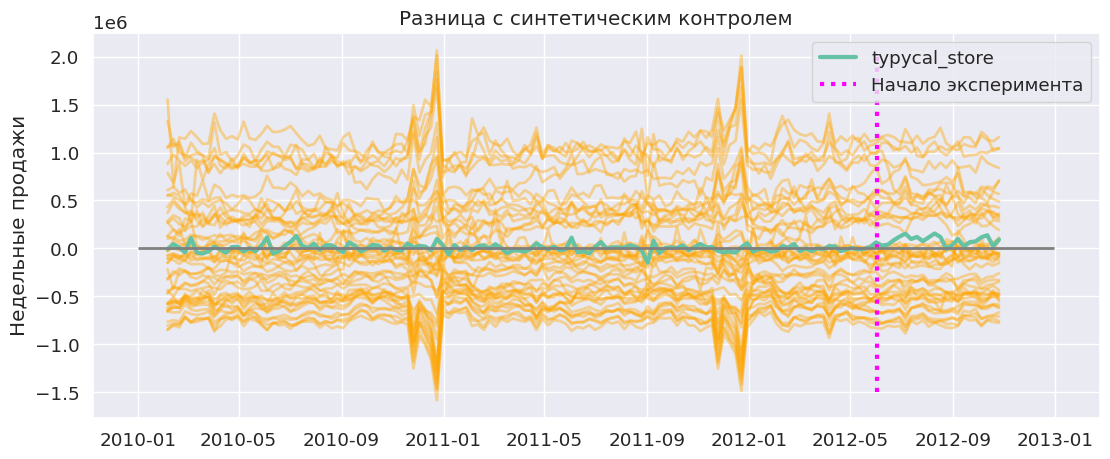

In [139]:
plt.figure(figsize=(13, 5))
for store in synthetic_stores:
    plt.plot(
        store["Date"], 
        store["Weekly_Sales"] - store["synthetic"], 
        color="orange",
        alpha=0.4,
        lw=2
    )

plt.plot(
    train.query("typycal_store")["Date"], 
    train.query("typycal_store")["Weekly_Sales"] - y_test_predict,
    label="typycal_store",
    lw=3
);

plt.vlines(
    x=pd.Timestamp("2012-06-02"), ymin=-1.5e6, ymax=2e6, linestyle=":", lw=3, 
    color="magenta", label="Начало эксперимента")
plt.hlines(y=0, xmin=pd.Timestamp("2010-01-01"), xmax=pd.Timestamp("2012-12-31"), lw=2, color="gray")

plt.title("Разница с синтетическим контролем")
plt.ylabel("Недельные продажи")
plt.legend()
plt.show();

In [140]:
y_test_predict = model.predict(X_test)

In [141]:
n_iter = 500
alpha = 0.20

type1_rejections = 0  # для ошибки первого рода
power_rejections = 0  # для мощности

for _ in tqdm(range(n_iter)):
    random_store = np.random.choice(train["Store"].unique())
    synth = synthetic_control(
        random_store, train, model=Lasso(alpha=1, positive=True)
    )

    parallel_fn = delayed(partial(synthetic_control, data=train, model=Lasso(alpha=1, positive=True, max_iter=10000)))
    synthetic_stores = Parallel(n_jobs=-1)(parallel_fn(store) for store in train["Store"].unique())

    effects = [
        state.query("after_treatment")["Weekly_Sales"].mean() - state.query("after_treatment")["synthetic"].mean()
        for state in synthetic_stores
    ]
    calif_effect = synth.query("after_treatment")["Weekly_Sales"].mean() * 1.05 - synth.query("after_treatment")["synthetic"].mean()
    pval = np.mean(np.array(effects) < calif_effect)
    
    if pval < alpha:
        type1_rejections += 1
    
    if calif_effect > 0:
        power_rejections += 1
    
type1_error = type1_rejections / n_iter
power = power_rejections / n_iter

print(f"Ошибка первого рода (Type I error) ≈ {type1_error:.3f}")
print(f"Мощность теста (Power)             ≈ {power:.3f}")


  0%|          | 0/500 [00:00<?, ?it/s]

Ошибка первого рода (Type I error) ≈ 0.026
Мощность теста (Power)             ≈ 0.918


**3.** Заметим, что для получения синтетического контроля более информативными являются те значения обучающей выборки, которые лежат ближе к экспериментальному периоду. Тем самым логично придать им больший вес.

Определите вес $w_i$, линейно возрастающий к началу эксперимента. Например, неделю 8 месяцев назад стоит брать с весом 0, неделю непосредственно перед экспериментом с весом 1.

Возьмем следующую формулу $\omega_i = \frac{t_i - t_{min}}{t_{max} - t_{min}}$

Получаем задачу оптимизации 
$$\begin{cases}
\sum\limits_{i=1}^n w_i (Y_i - x_i^T \theta) + \lambda \|\theta\|^2 \longrightarrow \min\limits_\theta;\\
\theta_1 + ... + \theta_d = 1;\\
\theta_j \geqslant 0, \ j=1,...,d.
\end{cases}$$

Предсказание получается обычным образом как $\widehat{y}(x) = x^T \theta$.

Постройте синтетический контроль с помощью такой задачи оптимизации и провалидируйте его.

*Примечания.*
1. Можно использовать известные пакеты для решения задач оптимизации.
2. На частичный балл можно решить задачу без ограничений по явной формуле.

In [142]:
from scipy.optimize import minimize

def synthetic_control_weighted(store, data, lambda_reg=1.0):
    # Подготовка данных
    tmp = data.copy()
    tmp['Date'] = pd.to_datetime(tmp['Date'])

    # Обучающий период и полный период
    train_df = tmp[(tmp['Date'] >= start_date) & (tmp['Date'] < experiment_start_date)].copy()
    full_df = tmp.copy()

    # Агрегируем Weekly_Sales
    train_agg = (train_df.groupby(['Store', 'Date'])['Weekly_Sales']
                        .sum().reset_index())
    full_agg = (full_df.groupby(['Store', 'Date'])['Weekly_Sales']
                       .sum().reset_index())

    # Добавляем флаг вмешательства
    full_flags = full_df[['Store', 'Date', 'after_treatment']].drop_duplicates()
    full_agg = full_agg.merge(full_flags, on=['Store', 'Date'], how='left')

    # Пивотируем 
    train_pivot = train_agg.pivot(index='Date', columns='Store', values='Weekly_Sales').fillna(0)
    full_pivot = full_agg.pivot(index='Date', columns='Store', values='Weekly_Sales').fillna(0)

    # y и X для обучения
    y_train = train_pivot[store].values
    X_train = train_pivot.drop(columns=store).values

    # Расчет весов w_i
    dates = train_pivot.index.values.astype('datetime64[D]')
    t_min = np.datetime64(start_date, 'D')
    t_max = np.datetime64(experiment_start_date, 'D')
    week_offsets = (dates - t_min) / np.timedelta64(1, 'W')
    total_weeks = (t_max - t_min) / np.timedelta64(1, 'W')
    w = week_offsets / total_weeks

    # Функция потерь
    def objective(theta):
        residuals = y_train - X_train.dot(theta)
        weighted_mse = np.sum(w * residuals**2)
        reg = lambda_reg * np.sum(theta**2)
        return weighted_mse + reg

    # Начальное приближение и ограничения
    d = X_train.shape[1]
    x0 = np.ones(d) / d
    constraints = ({'type': 'eq', 'fun': lambda th: np.sum(th) - 1})
    bounds = [(0, None)] * d

    # Решаем задачу SLSQP
    res = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    theta = res.x

    # Предсказание на полный период
    X_full = full_pivot.drop(columns=store).values
    y_pred = X_full.dot(theta)

    # Собираем результат
    result = (full_agg[full_agg['Store'] == store]
              [['Store', 'Date', 'Weekly_Sales', 'after_treatment']].copy())
    result['synthetic'] = y_pred
    return result

In [143]:
type1_rejections = 0  # для ошибки первого рода
power_rejections = 0  # для мощности

for _ in tqdm(range(n_iter)):
    random_store = np.random.choice(train["Store"].unique())
    synth = synthetic_control_weighted(
        random_store, train, lambda_reg=1.0
    )

    parallel_fn = delayed(partial(synthetic_control_weighted, data=train, lambda_reg=1.0))
    synthetic_stores = Parallel(n_jobs=-1)(parallel_fn(store) for store in train["Store"].unique())

    effects = [
        state.query("after_treatment")["Weekly_Sales"].mean() - state.query("after_treatment")["synthetic"].mean()
        for state in synthetic_stores
    ]
    calif_effect = synth.query("after_treatment")["Weekly_Sales"].mean() * 1.05 - synth.query("after_treatment")["synthetic"].mean()
    pval = np.mean(np.array(effects) < calif_effect)
    
    if pval < alpha:
        type1_rejections += 1
    
    if calif_effect > 0:
        power_rejections += 1
    
type1_error = type1_rejections / n_iter
power = power_rejections / n_iter

print(f"Ошибка первого рода (Type I error) ≈ {type1_error:.3f}")
print(f"Мощность теста (Power)             ≈ {power:.3f}")


  0%|          | 0/500 [00:00<?, ?it/s]

Ошибка первого рода (Type I error) ≈ 0.208
Мощность теста (Power)             ≈ 0.302


**4.** Простройте синтетический контроль с помощью любой другой модели и провалидируйте его. Например, это может быть прогнозирование временных рядов, причем для прогноза контрафактивного исхода в тестовом магазине можно использовать текущие наблюдаемые исходы в контрольных магазинах. Можно брать любые модели &mdash; линейные, бустинги, нейросети.

In [145]:
type1_rejections = 0  # для ошибки первого рода
power_rejections = 0  # для мощности

for _ in tqdm(range(n_iter)):
    random_store = np.random.choice(train["Store"].unique())
    synth = synthetic_control(
        random_store, train, model=XGBRegressor()
    )

    parallel_fn = delayed(partial(synthetic_control, data=train, model=XGBRegressor()))
    synthetic_stores = Parallel(n_jobs=-1)(parallel_fn(store) for store in train["Store"].unique())

    effects = [
        state.query("after_treatment")["Weekly_Sales"].mean() - state.query("after_treatment")["synthetic"].mean()
        for state in synthetic_stores
    ]
    calif_effect = synth.query("after_treatment")["Weekly_Sales"].mean() * 1.05 - synth.query("after_treatment")["synthetic"].mean()
    pval = np.mean(np.array(effects) < calif_effect)
    
    if pval < alpha:
        type1_rejections += 1
    
    if calif_effect > 0:
        power_rejections += 1
    
type1_error = type1_rejections / n_iter
power = power_rejections / n_iter

print(f"Ошибка первого рода (Type I error) ≈ {type1_error:.3f}")
print(f"Мощность теста (Power)             ≈ {power:.3f}")

  0%|          | 0/500 [00:00<?, ?it/s]

Ошибка первого рода (Type I error) ≈ 0.030
Мощность теста (Power)             ≈ 0.930


**5.** Постройте байесовскую модель синтетического контроля и сравните ее результаты с другими подходами.

In [148]:
def synthetic_control_bayesian(store, data):

    tmp_train = data.copy()
    tmp_train["Date"] = pd.to_datetime(tmp_train["Date"])
    general_df = tmp_train.copy()

    tmp_train = tmp_train[
        (tmp_train["Date"] <= experiment_start_date) & (tmp_train["Date"] >= start_date)
    ]
    general_df = (
        general_df.groupby(["Store", "Date"])["Weekly_Sales"].sum().reset_index()
    )
    general_df.set_index("Date", inplace=True)
    general_pivot = general_df.pivot(columns="Store", values="Weekly_Sales")

    tmp_train = tmp_train.groupby(["Store", "Date"])["Weekly_Sales"].sum().reset_index()
    tmp_train.set_index("Date", inplace=True)
    train_pivot = tmp_train.pivot(columns="Store", values="Weekly_Sales")

    y_train = train_pivot[store].values
    X_train = train_pivot.drop(columns=store).values

    X_test = general_pivot.drop(columns=store).values

    with pm.Model() as model:
        theta = pm.Dirichlet("theta", a=np.ones(X_train.shape[1]))
        sigma = pm.HalfNormal("sigma", sigma=1.0)
        mu = pm.math.dot(X_train, theta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)
        trace = pm.sample(20, tune=10, cores=1, target_accept=0.8, random_seed=42, progressbar=False)

    theta_samples = trace.posterior["theta"].stack(sample=("chain", "draw")).values
    y_test_predict_samples = X_test @ theta_samples

    y_test_predict_mean = np.mean(y_test_predict_samples, axis=1)

    return data.query(f"Store=={store}")[
        ["Store", "Date", "Weekly_Sales", "after_treatment"]
    ].assign(synthetic=y_test_predict_mean)

In [149]:
type1_rejections = 0  # для ошибки первого рода
power_rejections = 0  # для мощности
n_iter = 10

for _ in tqdm(range(n_iter)):
    random_store = np.random.choice(train["Store"].unique())
    synth = synthetic_control_bayesian(
        random_store, train
    )

    parallel_fn = delayed(partial(synthetic_control_bayesian, data=train))
    synthetic_stores = Parallel(n_jobs=-1)(parallel_fn(store) for store in train["Store"].unique())

    effects = [
        state.query("after_treatment")["Weekly_Sales"].mean() - state.query("after_treatment")["synthetic"].mean()
        for state in synthetic_stores
    ]
    calif_effect = synth.query("after_treatment")["Weekly_Sales"].mean() * 1.05 - synth.query("after_treatment")["synthetic"].mean()
    pval = np.mean(np.array(effects) < calif_effect)
    
    if pval < alpha:
        type1_rejections += 1
    
    if calif_effect > 0:
        power_rejections += 1
    
type1_error = type1_rejections / n_iter
power = power_rejections / n_iter

  0%|          | 0/10 [00:00<?, ?it/s]

Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, sigma]
Sampling 2 chains for 10 tune and 20 draw iterations (20 + 40 draws total) took 0 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for ac

In [150]:
print(f"Ошибка первого рода (Type I error) ≈ {type1_error:.3f}")
print(f"Мощность теста (Power)             ≈ {power:.3f}")

Ошибка первого рода (Type I error) ≈ 0.200
Мощность теста (Power)             ≈ 0.800


Сделайте выводы.

**Выводы**

Мы видим неплохой результат со стороны Lasso регрессии в детектировании эффекта.

Лучшим же оказался бустинг, что ожидаемо, он имеет лучшую предсказательную способность.

Заметим, что учет весов не принес желаемого эффекта.

---
### Задача 2.

Повторите исследования из задачи CI.3.2 для метода инструментальных признаков, генерируя два типа данных:
* тритмент, таргет, инструмент;
* тритмент, таргет, инструмент, конфаундер.

Мы предполагаем, что конфаундер ненаблюдаем. В этих условиях сравните метод инструментальных признаков с простым t-test.

In [151]:
def metric_power(estimations, left, right, true_effect=0):
    """
    Вероятность отвержения гипотезы H0: theta = 0.
    Если true_effect == 0, метрика измеряет вероятность ошибки I рода.
    Если true_effect != 0, метрика измеряет мощность.

    estimations -- массив оценок причинно-следственного эффекта
    left, right -- массивы для левой и правой границ доверительного
                   интервала причинно-следственного эффекта
    true_effect -- истинное значение причинно-следственного эффекта (по умолчанию 0)
    """
    rejected = (0 < left) | (0 > right)  # т.е. 0 не входит в CI
    return rejected.mean()


def metric_mape(estimations, left, right, true_effect=0):
    if true_effect == 0:
        raise ValueError("MAPE не определён при true_effect = 0")
    true_effect_array = np.full_like(estimations, true_effect, dtype=float)
    return mape(true_effect_array, estimations)


def metric_coverage(estimations, left, right, true_effect=0):
    covered = (left <= true_effect) & (right >= true_effect)
    return covered.mean()


def metric_length(estimations, left, right, true_effect=0):
    return (right - left).mean()

In [152]:
def generate_data(
    effect=0,
    sample_size=1000,
    n_confounders=1,
    n_instruments=0,
    n_covariates=1,
    w_t_coefs=None,
    w_y_coefs=None,
    z_t_coefs=None,
    x_y_coefs=None,
):
    """
    Генерирует DataFrame с колонками:
      - y           — таргет
      - T           — бинарный тритмент
      - W_0..W_{n_confounders-1} — конфаундеры
      - Z_0..Z_{n_instruments-1} — инструменты
      - X_0..X_{n_covariates-1}  — ковариаты
    """
    # 1) Подготовим коэффициенты
    if n_confounders > 0:
        locs_w = np.random.uniform(-1, 1, size=n_confounders)
        w_t_coefs = (np.full(n_confounders, 0.01)
                     if w_t_coefs is None else np.array(w_t_coefs))
        w_y_coefs = (np.full(n_confounders, 1.0)
                     if w_y_coefs is None else np.array(w_y_coefs))
    if n_instruments > 0:
        locs_z = np.random.uniform(-1, 1, size=n_instruments)
        z_t_coefs = (np.full(n_instruments, 0.01)
                     if z_t_coefs is None else np.array(z_t_coefs))
    if n_covariates > 0:
        locs_x = np.random.uniform(-1, 1, size=n_covariates)
        x_y_coefs = (np.full(n_covariates, 1.0)
                     if x_y_coefs is None else np.array(x_y_coefs))

    # 2) Заведём названия колонок и пустой DataFrame
    cols = ["y", "T"] \
           + [f"W_{i}" for i in range(n_confounders)] \
           + [f"Z_{i}" for i in range(n_instruments)] \
           + [f"X_{i}" for i in range(n_covariates)]
    data = pd.DataFrame(index=np.arange(sample_size), columns=cols)

    # 3) Генерируем смещение p_bias и loc_bias
    p_bias = np.zeros(sample_size)
    loc_bias = np.zeros(sample_size)

    # 3.1 Конфаундеры
    for i in range(n_confounders):
        w = np.random.normal(locs_w[i], scale=1.0, size=sample_size)
        data[f"W_{i}"] = w
        p_bias   += w_t_coefs[i] * w
        loc_bias += w_y_coefs[i] * w

    # 3.2 Инструменты
    for i in range(n_instruments):
        z = np.random.normal(locs_z[i], scale=1.0, size=sample_size)
        data[f"Z_{i}"] = z
        p_bias += z_t_coefs[i] * z

    # 3.3 Ковариаты
    for i in range(n_covariates):
        x = np.random.normal(locs_x[i], scale=1.0, size=sample_size)
        data[f"X_{i}"] = x
        loc_bias += x_y_coefs[i] * x

    # 4) Собираем тритмент
    p = np.clip(0.5 + p_bias, 0, 1)                     # вероятность
    t = np.random.binomial(1, p, size=sample_size)      # 0/1
    data["T"] = t

    # 5) Генерируем таргет с учётом истинного эффекта
    loc = loc_bias + effect * t
    y = np.random.normal(loc, scale=1.0, size=sample_size)
    data["y"] = y

    return data

In [153]:
def causal_model_test(
    data,
    names_dict=defaultdict(list, {"treatment": "T", "target": "y"}),
    method="backdoor.propensity_score_weighting",
    alpha=0.05,
    bs_sims=2,             # ← Новое: число бутстрэп-репликаций
    bs_frac=1.0,             # ← Новое: доля подвыборки в каждой репликации
):
    """
    Применяет метод оценки причинного эффекта с использованием DoWhy.

    Параметры
    ----------
    data: pd.DataFrame
        Данные с колонками: treatment, target, confounders, instruments, covariates
    names_dict: defaultdict(list)
        Словарь с именами переменных (ключи: "treatment", "target", "confounders", "instruments", "covariates")
    method: str
        Метод DoWhy для оценки эффекта, например: "backdoor.linear_regression"
    alpha: float
        Уровень значимости (1 - уровень доверия)
    bs_sims: int
        Число бутстрэп-репликаций для оценки доверительных интервалов
    bs_frac: float
        Доля исходной выборки, используемой в каждой бутстрэп-репликации

    Возвращает
    ----------
    estimation: float
        Оценка эффекта
    left_bound: float
        Левая граница доверительного интервала (если возможно, иначе np.nan)
    right_bound: float
        Правая граница доверительного интервала (если возможно, иначе np.nan)
    """
    # объявляем модель
    model = CausalModel(
        data=data,
        treatment=names_dict["treatment"],
        outcome=names_dict["target"],
        common_causes=names_dict["confounders"],
        instruments=names_dict["instruments"],
        effect_modifiers=names_dict["covariates"],
    )

    # идентификация
    identified_estimand = model.identify_effect()

    # параметры метода
    if method.startswith("backdoor.econml"):
        method_spec = {
            "init_params": {
                "model_propensity": "linear",
                "model_regression": "linear",
            },
            "fit_params": {"inference": "bootstrap"},
            "num_simulations": bs_sims,
            "sample_size_fraction": bs_frac,
        }
    else:
        method_spec = {
            "num_simulations": bs_sims,
            "sample_size_fraction": bs_frac,
        }

    # оценка эффекта
    estimate = model.estimate_effect(
        identified_estimand,
        method_name=method,
        method_params=method_spec,
        confidence_intervals="bootstrap",
    )

    estimation = estimate.value

    # попытка получить доверительный интервал
    try:
        ci = estimate.get_confidence_intervals(confidence_level=1 - alpha)
        left_bound, right_bound = np.squeeze(ci)
    except Exception:
        left_bound, right_bound = np.nan, np.nan

    return estimation, left_bound, right_bound


In [154]:
n_iter = 1000
effect = 0.05
sample_size = 1000
jobs = -1

In [155]:
models_results = {
    "vanila_ttest": {"estimations": [], "ci": []},
    "statsmodels": {"estimations": [], "ci": []},
    "dowhy": {"estimations": [], "ci": []},
}
configs = [
    {
        "effect": effect,
        "sample_size": sample_size,
        "n_confounders": 0,
        "n_instruments": 2,
        "n_covariates": 0,
    },  # только тритмент, таргет, 2 инструмента
    {
        "effect": effect,
        "sample_size": sample_size,
        "n_confounders": 2,
        "n_instruments": 2,
        "n_covariates": 0,
    },  # только тритмент, таргет, 2 инструмента, 2 скрытых конфаундера
]

config_variable_names = [
    {
        "treatment": "T",
        "target": "y",
        "covariates": [],
        "confounders": [],
        "instruments": ["Z_0", "Z_1"],
    },
    {
        "treatment": "T",
        "target": "y",
        "covariates": [],
        "confounders": [],
        "instruments": ["Z_0", "Z_1"],
    },
]

In [156]:
def process_iteration(cfg_idx, name, names_dict, method, cfg):
    """Обрабатывает одну итерацию симуляции"""
    data = generate_data(**cfg)
    est, lb, rb = causal_model_test(data, 
                                   names_dict=names_dict,
                                   method=method)
    return {
        "config": cfg_idx,
        "model": name,
        "estimate": est,
        "ci_low": lb,
        "ci_high": rb,
    }

raw = []
model_specs = [
    ("T‑test DoWhy‑LR",      config_variable_names[0], "backdoor.linear_regression"),
    ("Instrumental Variable DoWhy‑LR",      config_variable_names[0], "iv.instrumental_variable"),

]

for cfg_idx, cfg in enumerate(configs):
    for name, names_dict, method in model_specs:
        tasks = (delayed(process_iteration)(cfg_idx, name, names_dict, method, cfg)
                 for _ in range(n_iter))
        
        results = Parallel(n_jobs=jobs, verbose=0)(
            tqdm(tasks, 
                 desc=f"Config {cfg_idx} → {name}", 
                 total=n_iter)
        )
        
        raw.extend(results)

Config 0 → T‑test DoWhy‑LR:   0%|          | 0/1000 [00:00<?, ?it/s]

Config 0 → Instrumental Variable DoWhy‑LR:   0%|          | 0/1000 [00:00<?, ?it/s]

Config 1 → T‑test DoWhy‑LR:   0%|          | 0/1000 [00:00<?, ?it/s]

Config 1 → Instrumental Variable DoWhy‑LR:   0%|          | 0/1000 [00:00<?, ?it/s]

In [157]:
def compute_group_metrics(g):
    est = g["estimate"].values
    lb = g["ci_low"].values
    rb = g["ci_high"].values
    return pd.Series(
        {
            "power": round(metric_power(est, lb, rb, true_effect=effect), 3),
            "coverage": round(metric_coverage(est, lb, rb, true_effect=effect), 3),
            "length": round(metric_length(est, lb, rb, true_effect=effect), 3),
            **(
                {"mape": round(metric_mape(est, lb, rb, true_effect=effect), 3)}
                if effect != 0
                else {}
            ),
        }
    )

df = pd.DataFrame(raw)
metrics_df = df.groupby(["config", "model"]).apply(compute_group_metrics).reset_index()

metrics_df

,config,model,power,coverage,length,mape
0,0,Instrumental Variable DoWhy‑LR,0.684,0.348,0.148,2.997
1,0,T‑test DoWhy‑LR,0.731,0.338,0.071,0.970
2,1,Instrumental Variable DoWhy‑LR,0.947,0.066,0.287,27.091
3,1,T‑test DoWhy‑LR,0.784,0.286,0.124,2.246


**Выводы**


Как видим, в случае наличия скрытых конфаундеров инструментальный подход показывает большую мощность, но при этом его ошибка MAPE также больше.

T-test же демонстрирует умеренные результаты, но имеет меньшую мощность в случае наличия конфаундеров.